<a href="https://colab.research.google.com/github/LienVerboom/ML-course-VIB-2024/blob/master/notebooks/Histone_marks_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histone modifications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

random_seed = 123
np.random.seed(random_seed)

# 1. The data

Histone modifications play an important role in affecting gene regulation. Specific histone modifications at specific locations in or near the gene can alter the expression of genes. Predicting gene expression from histone modification signals is a widely studied research topic.

In this competition you will predict gene expression levels (low=0, high=1) based on the presence of histone modifications at specific locations in the gene. You will try to find the model that learns the true underlying model best.

For each gene a region of 10.000bp around the transcription start site of the gene is extracted (5000bp upstream and 5000bp downstream). This region is binned in 100 bins of 100bp. For each bin five core histone modification marks are counted [1].

The dataset is compiled from the "E047" (Primary T CD8+ naive cells from peripheral blood) celltype from Roadmap Epigenomics Mapping Consortium (REMC) database.

[1] Kundaje, A. et al. Integrative analysis of 111 reference human epige-
nomes. Nature, 518, 317–330, 2015.


We start by loading the Pandas library and reading the datasets into Pandas DataFrames:

In [17]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/compomics/ML-course-VIB-2024/refs/heads/master/data/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/compomics/ML-course-VIB-2024/refs/heads/master/data/data_test.csv")

Let's look at a random sample of the training set:

In [3]:
train.head(10)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,...,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99,Label
0,7008,1,1,2,1,3,1,2,5,0,...,11,15,5,2,2,10,12,2,2,1
1,9839,0,0,1,1,0,2,0,2,0,...,1,0,0,0,1,1,0,0,0,1
2,11972,7,3,1,1,1,4,2,1,1,...,1,0,2,0,1,1,1,1,0,0
3,14705,4,2,4,1,3,0,2,1,1,...,1,2,4,2,4,3,0,0,0,0
4,12058,1,1,2,0,8,0,2,1,1,...,1,2,2,1,0,1,1,1,0,1
5,10442,1,2,1,2,0,0,1,1,1,...,0,0,2,0,3,0,1,1,0,1
6,6940,0,1,0,2,0,0,0,0,0,...,0,1,1,2,2,0,0,1,3,1
7,12867,1,1,14,1,1,1,2,13,5,...,0,6,1,4,1,1,2,2,1,1
8,13297,0,0,0,2,2,3,3,4,0,...,7,0,3,3,0,9,0,4,7,1
9,8046,0,3,0,11,0,0,1,1,14,...,5,4,2,0,1,9,6,2,2,1


An alternative visualization for this type of counting data is the heatmap.

With pop we remove a column and at the same time it can be assigned to a variable:

In [4]:
train_ids = train.pop("GeneId")

The ".head()" function returns the first rows of the dataframe:

In [5]:
train.head()

,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,...,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99,Label
0,1,1,2,1,3,1,2,5,0,1,...,11,15,5,2,2,10,12,2,2,1
1,0,0,1,1,0,2,0,2,0,2,...,1,0,0,0,1,1,0,0,0,1
2,7,3,1,1,1,4,2,1,1,2,...,1,0,2,0,1,1,1,1,0,0
3,4,2,4,1,3,0,2,1,1,3,...,1,2,4,2,4,3,0,0,0,0
4,1,1,2,0,8,0,2,1,1,3,...,1,2,2,1,0,1,1,1,0,1


With "sample" we get a specified number of random rows back. These are visualized with the seaborn "heatmap" function:

<Axes: >

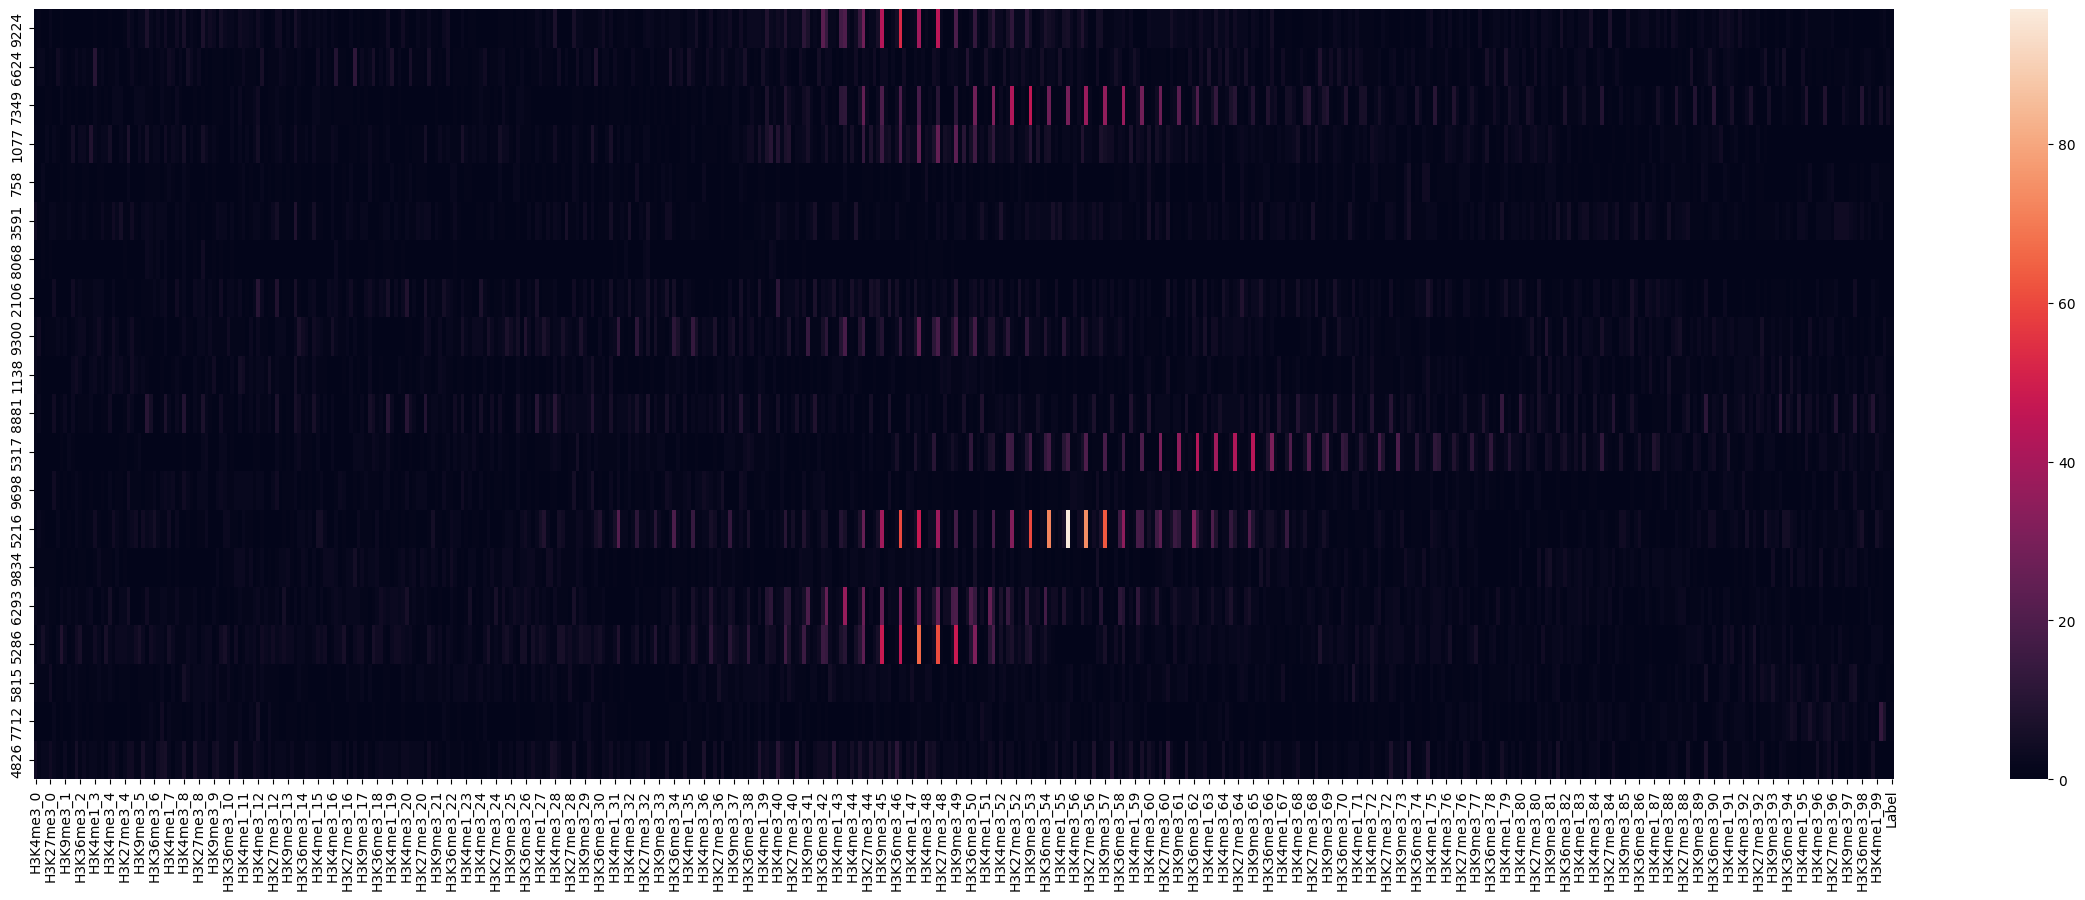

In [6]:
import seaborn as sns

plt.figure(figsize=(30,10))
sns.heatmap(train.sample(20))

The label for each datapoint is in the `Label` column.

In [7]:
train_labels = train.pop("Label")

In [8]:
train_labels

,Label
0,1
1,1
2,0
3,0
4,1
...,...
10431,0
10432,0
10433,1
10434,1


Now `train` contains the feature columns only.

Let's look at the number datapoints in each class:

In [9]:
train_labels.value_counts()

,count
Label,
1,5250
0,5186


Let's look at `test`:

In [10]:
test.head(5)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,...,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
0,5222,2,2,7,2,0,3,2,9,2,...,0,2,1,1,0,0,3,1,1,1
1,891,1,2,0,0,1,0,4,1,2,...,3,2,2,2,0,4,2,5,2,1
2,7219,1,1,2,4,4,2,2,1,1,...,1,3,1,1,0,0,1,1,1,0
3,7225,1,5,2,4,1,0,8,3,4,...,0,2,1,1,2,1,1,0,2,0
4,9432,1,16,3,2,2,2,7,0,4,...,0,1,2,0,1,1,1,1,2,1


This is a blind test so the `Label` column is not available in the test set. The test set does contain the `GeneId` column that can be used as unique identifiers for each row in the test set.


In [11]:
test_index_col = test.pop("GeneId")

We can compute some decriptive statistics about the training set using the DataFrame `.describe()` function:

In [12]:
train.describe()

,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,...,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
count,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,...,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000
mean,1.482081,1.738885,2.342564,1.887792,1.134438,1.486393,1.738310,2.354159,1.906957,1.121694,...,1.458413,1.754120,2.437236,1.800882,1.141050,1.455922,1.738022,2.397183,1.826945,1.129935
std,1.883112,2.098565,3.798700,5.292531,1.455765,1.925768,2.094562,3.784454,5.334868,1.417511,...,1.840630,2.155949,3.950022,4.797043,1.455172,1.842602,2.134836,3.892699,4.924786,1.472372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000
max,21.000000,24.000000,45.000000,104.000000,41.000000,42.000000,21.000000,42.000000,100.000000,25.000000,...,20.000000,22.000000,38.000000,99.000000,29.000000,27.000000,35.000000,35.000000,115.000000,43.000000


We can plot these descriptive statistics to get a general overview of the data.

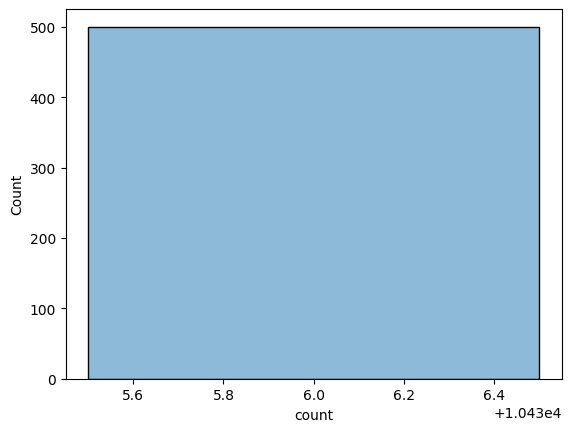

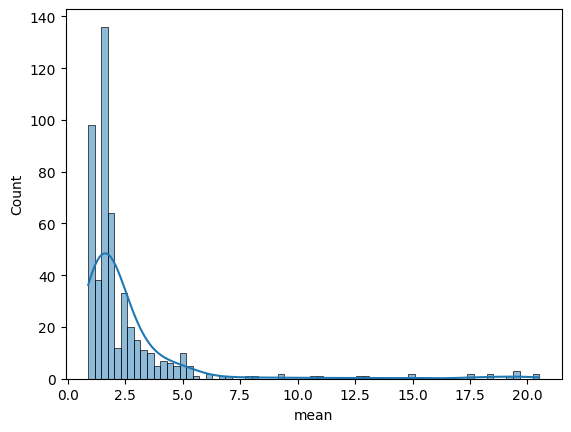

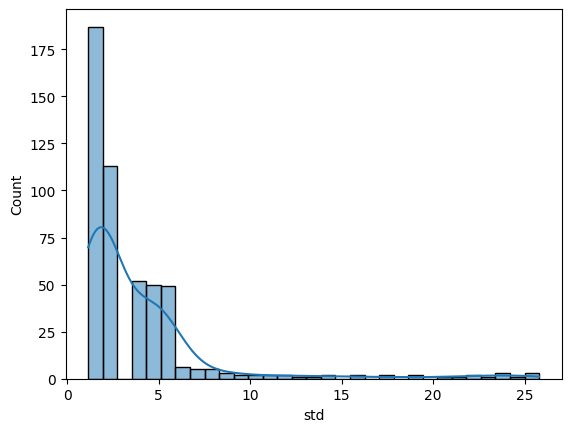

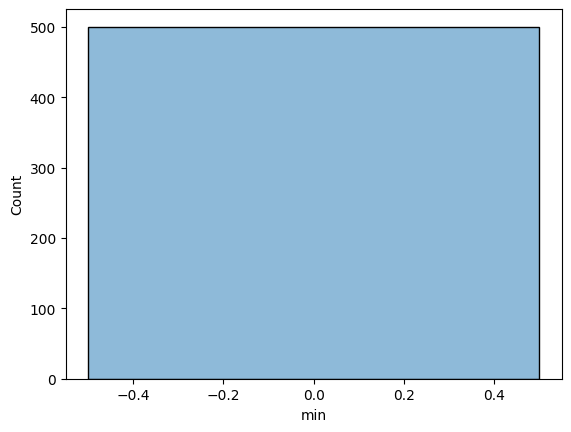

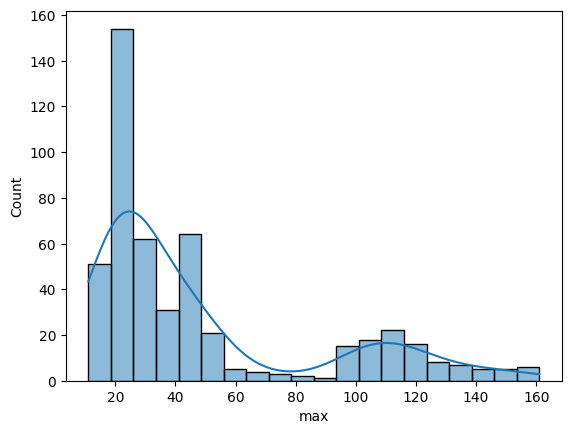

In [13]:
train_description = pd.DataFrame(train.describe().transpose())
for col in ["count","mean","std","min","max"]:
    sns.histplot(train_description[col], kde=True)
    plt.show()

We can use the Pandas `boxplot()` function to plot the feature values.

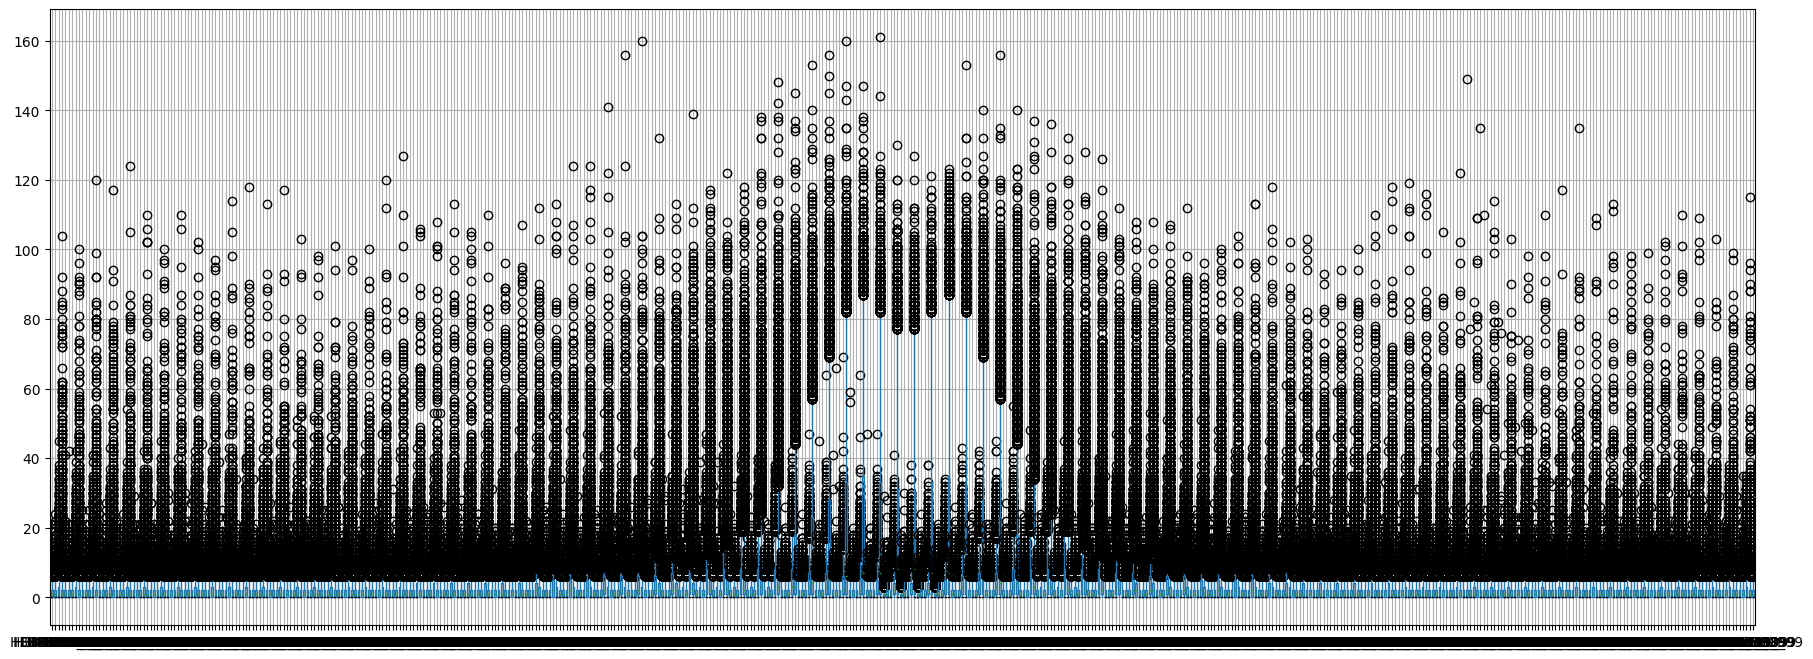

In [14]:
plt.figure(figsize=(22,8))
train.boxplot()
plt.show()

Let's plot these for each histone marker. Here we use a list (or set) comprehension if you want to understand this please go here: https://realpython.com/videos/understand-list-comp-overview/

In [15]:
marks = {m.split("_")[0] for m in train.columns}
print(marks)

{'H3K4me1', 'H3K36me3', 'H3K4me3', 'H3K27me3', 'H3K9me3'}


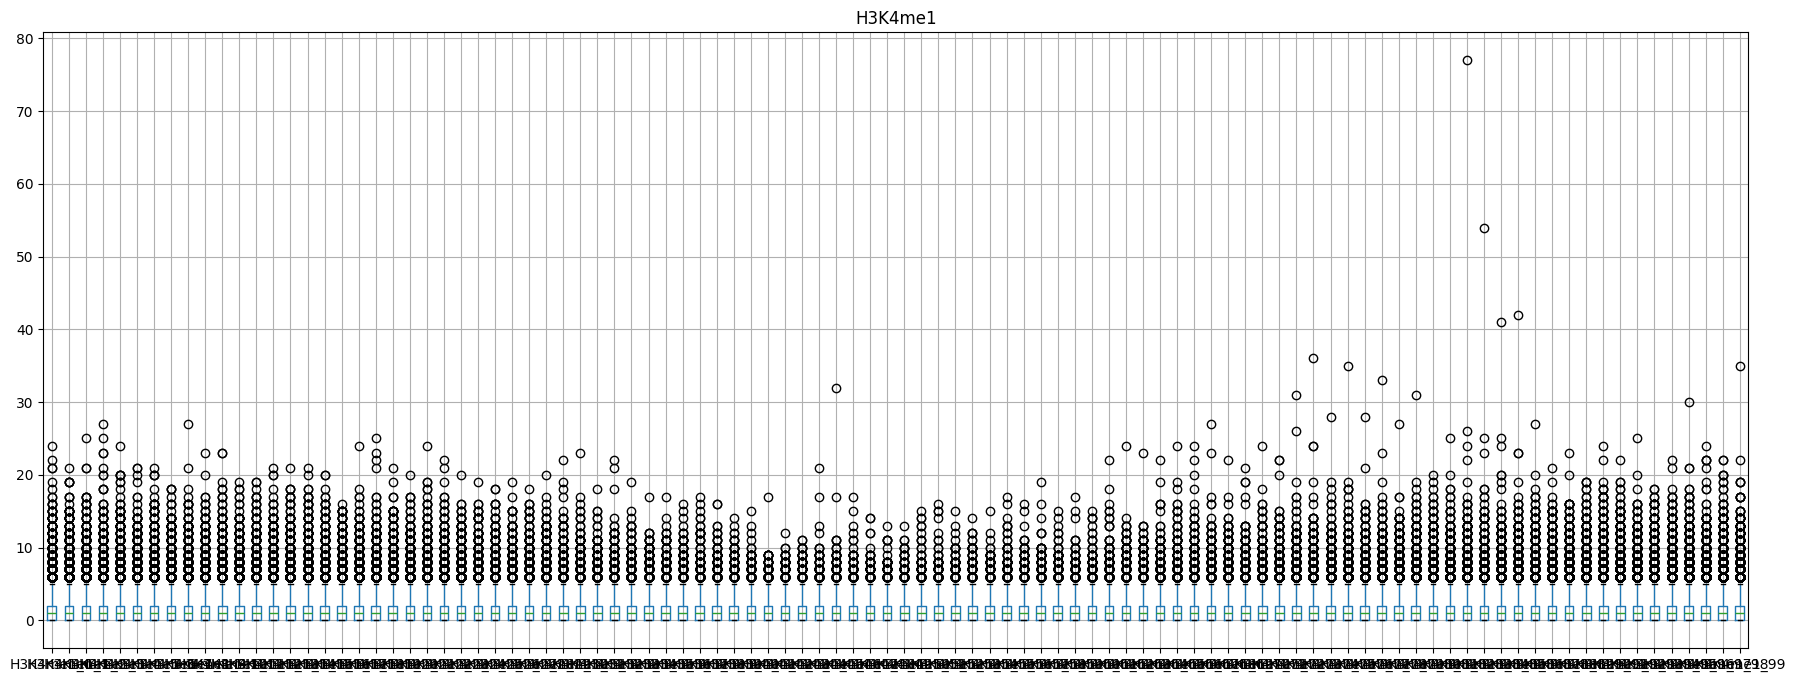

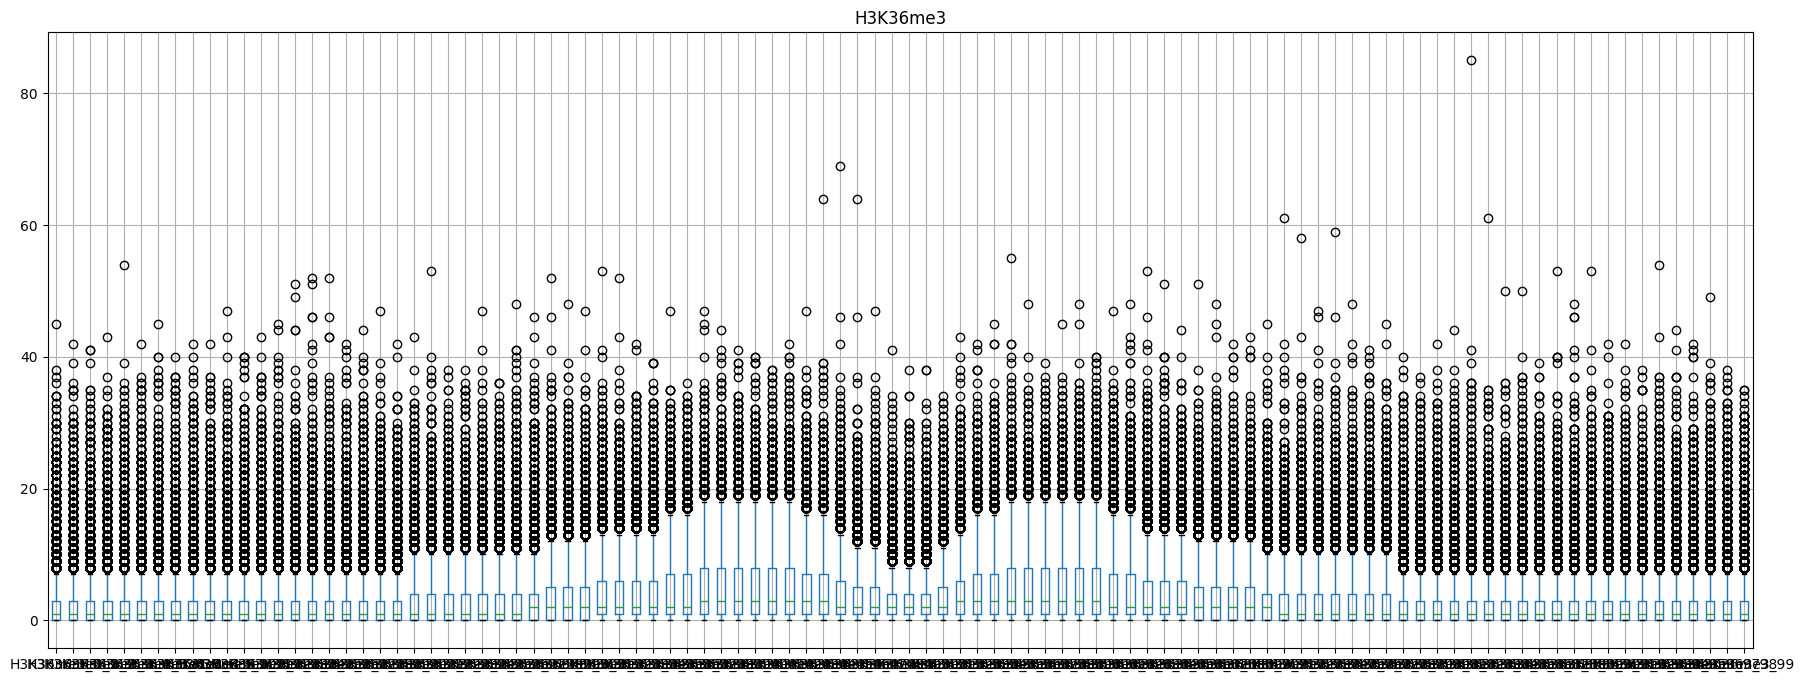

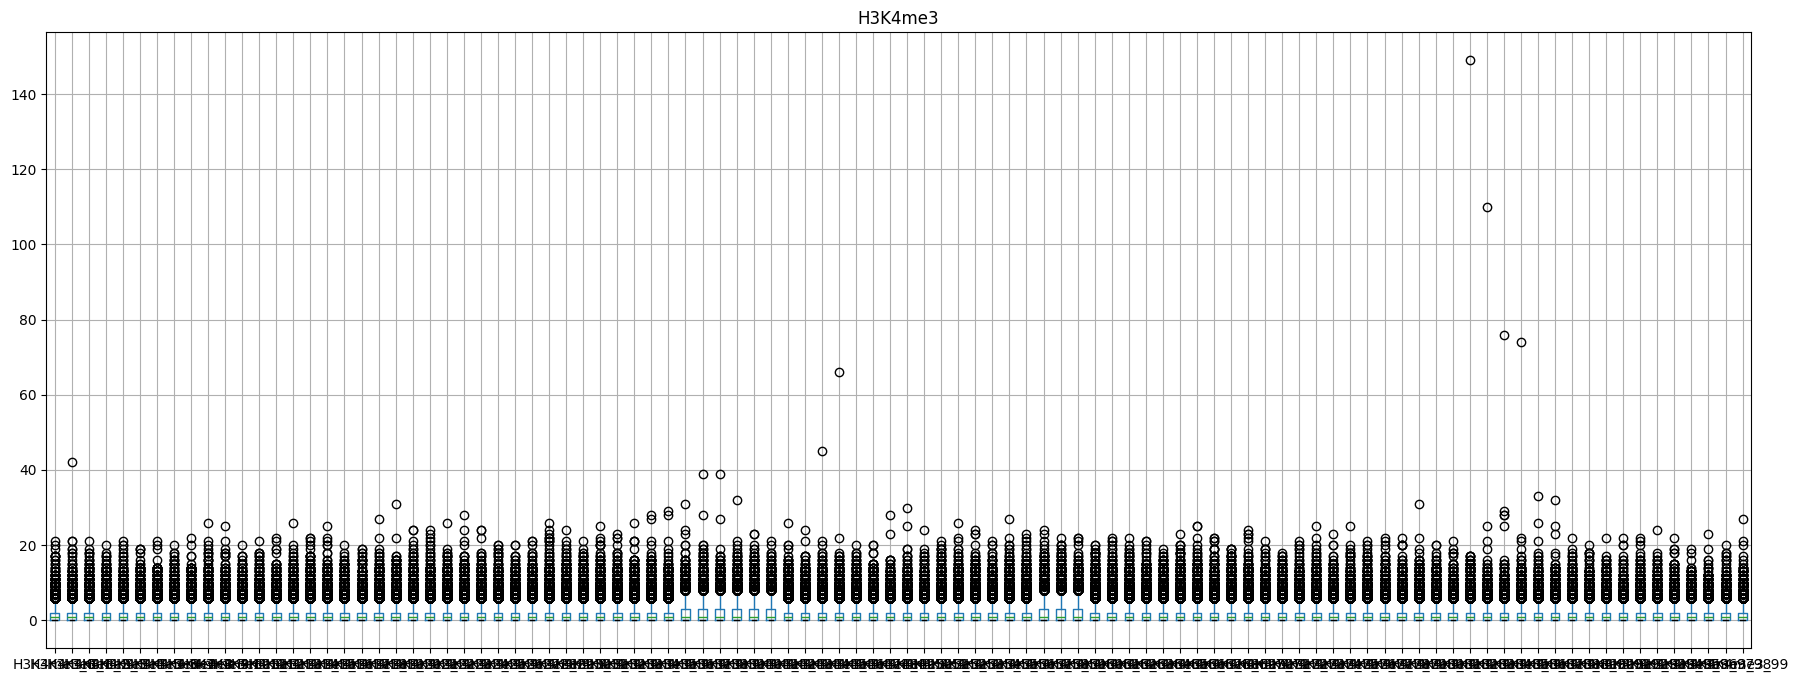

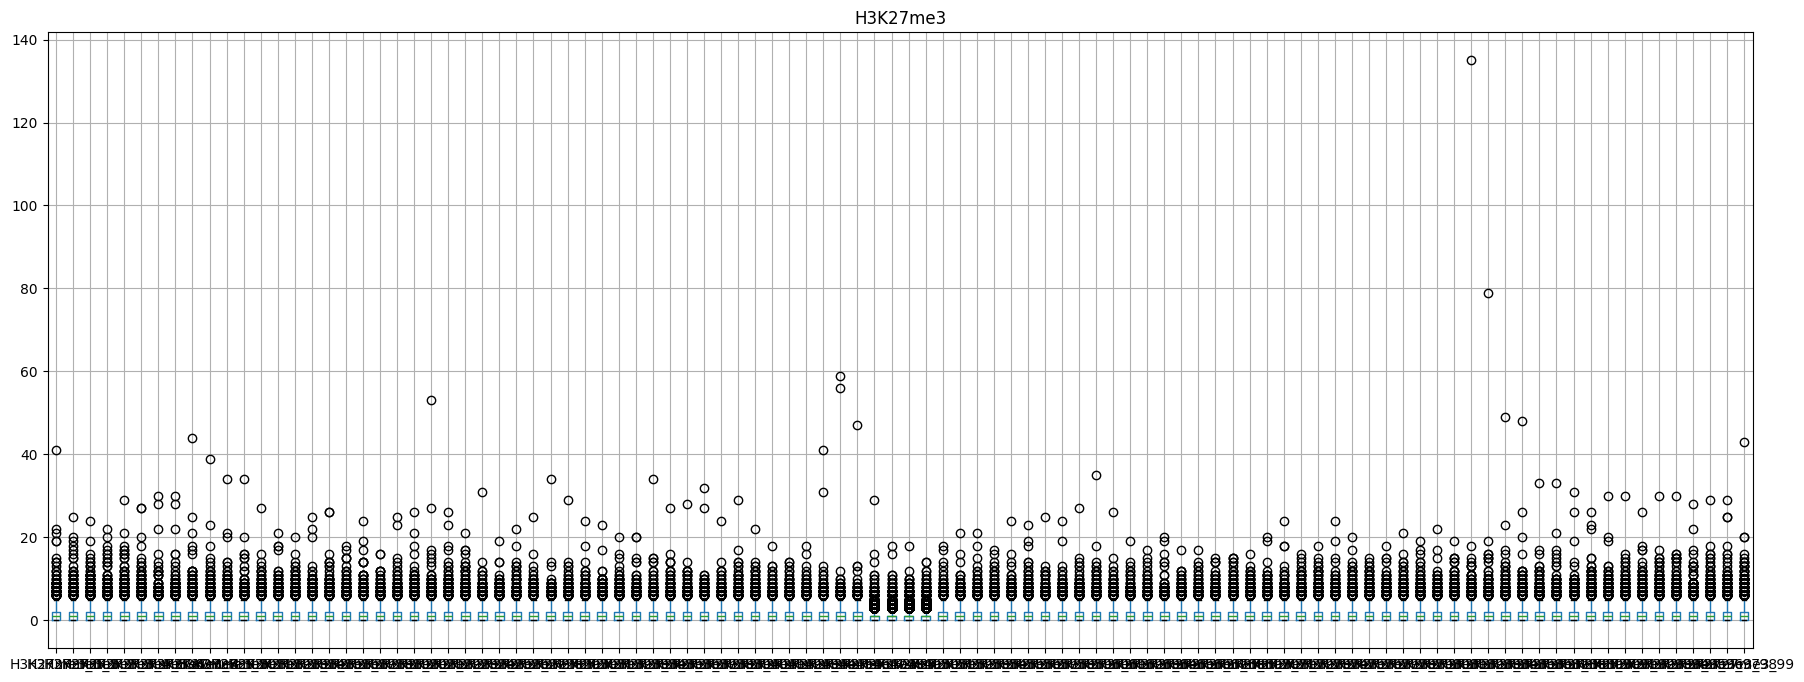

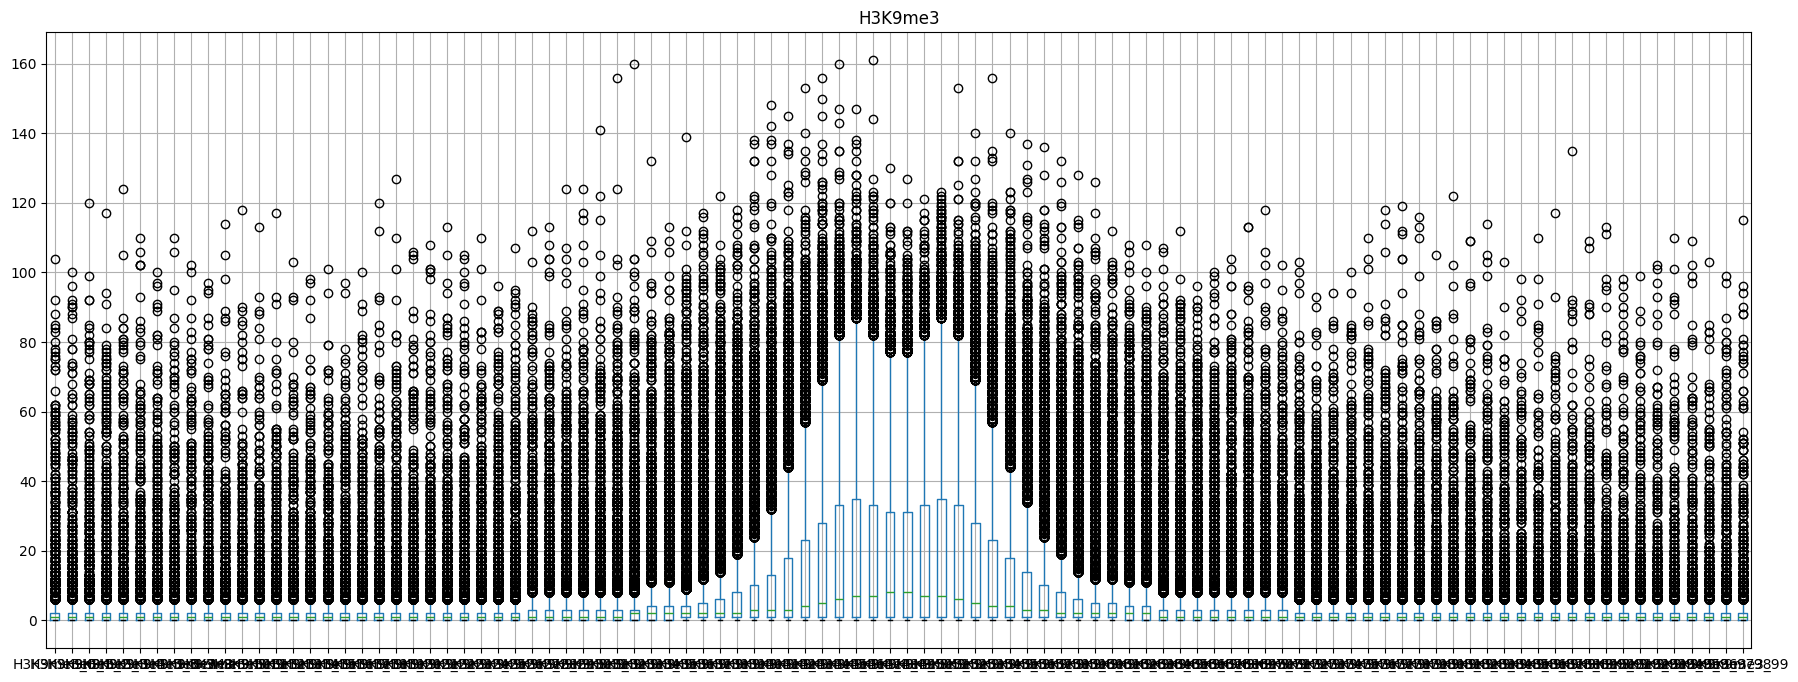

In [16]:
for mark in marks:
    # Identify those columns that start with the mark
    columns_selected = [c for c in train.columns if c.startswith(mark)]
    plt.figure(figsize=(22,8))
    train[columns_selected].boxplot()
    plt.title(mark)
    plt.show()

# 2. Our first model

Let's fit a Logistic Regression model. We will first use the very popular (with good reason) [Scikit-learn](https://scikit-learn.org/stable/) library for that.

First, we hold out 20% if the training data for independant validation.

Next, we fit the modelparameters on the training set and evaluate the fitted model on the validation set.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

# split the values in a train and validation set, for both the feature matrices and the target vector y
train_X, val_X, train_y, val_y = train_test_split(
    train,
    train_labels,
    test_size=.2, #20% of data
    random_state=random_seed  #make it reproducible
)

# initialize the model, set number of iterations (steps) for the gradient descent
cls = LogisticRegression(max_iter=10000)

# fit the model
cls.fit(train_X,train_y)

# obtain predictions for the test and validation set
#cls.predict_proba -- get predictions for class 0 and class 1
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

#% of predictions that is right
print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

Accuracy: (1.000000) 1.000000


In [19]:
cls

LogisticRegression(max_iter=10000)

# 3. How well does it perform in pratice?

In [20]:
#code for submission
predictions_test = cls.predict_proba(test)

to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = predictions_test[:,1]
to_write.to_csv("submission2.csv",index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Label


In [21]:
predictions_test[:,1]

NameError: name 'predictions_test' is not defined

A common metric is the log-loss, as this allows for evaluation probabilistic predictions:

$$ - \frac{1}{N} \sum_{i=1}^N [y_{i} \log \, p_{i} + (1 - y_{i}) \log \, (1 - p_{i})],$$

where $N$ is the number of datapoints, $y_i$ is the label of datapoint $i$, and $p_i$ is the prediction of the model expressed as a probability.

Let's compute the log-loss:

In [22]:
predictions_train = cls.predict_proba(train_X)[:,1]
predictions_val = cls.predict_proba(val_X)[:,1]

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train),log_loss(val_y,predictions_val)))

Log-loss: (0.002665) 0.003377


# 4. Data pre-processing




Let's scale all the features to [0,1]:

In [ ]:
from sklearn import preprocessing

scaler_minmax = preprocessing.MinMaxScaler()
scaler_minmax.fit(train)
train_norm = pd.DataFrame(scaler_minmax.transform(train),columns=train.columns)
train_norm.head()

In [ ]:
marks = {m.split("_")[0] for m in train_norm.columns}

for mark in marks:
    columns_selected = [c for c in train_norm.columns if c.startswith(mark)]
    plt.figure(figsize=(22,8))
    train_norm[columns_selected].boxplot()
    plt.title(mark)
    plt.show()

Now, did we improve the predictions?

In [ ]:
train_norm_X, val_norm_X, train_norm_y, val_norm_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls.fit(train_norm_X,train_norm_y)

predictions_norm_train = cls.predict(train_norm_X)
predictions_norm_val = cls.predict(val_norm_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_norm_train, train_norm_y),accuracy_score(predictions_norm_val, val_norm_y)))

predictions_norm_train_prob = cls.predict_proba(train_norm_X)
predictions_norm_val_prob = cls.predict_proba(val_norm_X)

print("Log-loss: (%f) %f"%(log_loss(train_norm_y,predictions_norm_train_prob[:,1]),log_loss(val_norm_y,predictions_norm_val_prob[:,1])))

# 5. Hyperparameter tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

Hyperparameters are an important part of the model and need to be tuned to achieve optimal performance. Here we will use scikit-learn to perform hyperparameter tuning

In [ ]:
train_norm_X, val_norm_X, train_norm_y, val_norm_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

First lets initialize the model itself:

In [ ]:
# Define the logistic regression model
log_reg = LogisticRegression(random_state=random_seed, max_iter=1000)

Define all hyperparameters to test, where each value of the dictionary is a hyperparameter and contains a list of values to test. You can set a specific to a single hyperparameter by defining a list with a single value (e.g., "regularization" : [1]).

In [ ]:
# Define the hyperparameter grid for C
#C is inverse of lambda ?, C determines the strength of our regularisation
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]}

Next, we define a gridsearch object that will execute the gridsearch and a cross-validation loop to estimate performance of each hyperparameter set.

In [ ]:
# Set up GridSearchCV with log-loss as the scoring metric
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid,
                           scoring='neg_log_loss', cv=5, verbose=42, n_jobs=-1)


The gridsearch object applies an grid search on the `tune_grid` where each point in the seach space is evaluated using cross-validation:

<br/>
<br/>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png"/>
<br/>
<br/>

We can now fit the model and tune the hyperparameter:

In [ ]:
# Fit the model on the training data
grid_search.fit(train_norm_X, train_norm_y)

We can ask the gridsearch object to return the best parameter:

In [ ]:
best_c = grid_search.best_params_['C']
print(f"Best C: {best_c}")

We can also ask the gridsearch object to obtain all the CV results and the corresponding log-loss values:

In [ ]:
# Extract results from GridSearchCV
results = grid_search.cv_results_

# Extract C values and their corresponding mean log-loss scores
c_values = param_grid['C']
mean_log_loss = -results['mean_test_score']  # Negate to get positive log-loss values

# Plot C-values vs log-loss
plt.figure(figsize=(8, 6))
plt.plot(c_values, mean_log_loss, marker='o', linestyle='-')
plt.xscale('log')  # Logarithmic scale for C-values
plt.xlabel('C (Inverse of Regularization Strength)', fontsize=12)
plt.ylabel('Log-Loss (Cross-Validation)', fontsize=12)
plt.title('Log-Loss vs C (Cross-Validation)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

There is a default parameters in the gridsearch object that defines that it will refit the model on all data for the best hyperparameter set. So there is no need to fit the model again for this specific best hyperparameter. We can get this fitted model by taking the "best_estimator_" variable from the object. Finally, lets see how this model with a tuned hyperparemeter performs on the validation set:

In [ ]:
# Evaluate on the validation set using log-loss
best_model = grid_search.best_estimator_
val_probabilities = best_model.predict_proba(val_norm_X)
val_log_loss = log_loss(val_norm_y, val_probabilities)
print(f"Validation Log-Loss: {val_log_loss:.4f}")

The low-complexity of the model allows for direct interpretation of the coefficients lets see what the most important features are:

In [ ]:
# Retrieve the coefficients of the best model
coefficients = best_model.coef_.flatten()  # Flatten in case there are multiple classes
features = train_norm_X.columns

# Create a DataFrame for better organization
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients to see most influential features
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
sorted_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 most important features
top_features = sorted_features.head(10)
print("Top 10 Important Features:")
print(top_features[['Feature', 'Coefficient']])

# Bar plot of top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Most Important Features in Logistic Regression', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()